# Tutorial CNN with CIFAR-10 dataset

```
cd /tmp
curl -L -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -zxvf cifar-100-python.tar.gz
```

In [49]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def load(file):    
    data = pickle.load(open(file, "rb"), encoding='latin1') 
    return np.array(data["data"], dtype='float32'), np.array(data["labels"], dtype='int32')

def asclass(i):
    data = np.zeros(10, dtype='float32')
    data[i] = 1
    return data

X = np.empty([0,32, 32, 3])
Y = np.empty([0,  10])
    
for i in range(1, 6):
    data, labels = load("/tmp/cifar-10-batches-py/data_batch_" + str(i))
    data = data.reshape((len(data),3,32,32)).transpose(0,2,3,1)
    labels = labels.reshape((len(labels), 1))
    klass = np.apply_along_axis(asclass, 1, labels)
    X = np.concatenate([X, data], axis=0)
    Y = np.concatenate([Y, klass], axis=0)

Xtest, Ytest = load("/tmp/cifar-10-batches-py/test_batch")
Xtest = Xtest.reshape((len(data),3,32,32)).transpose(0,2,3,1)
Ytest = Ytest.reshape((len(Ytest), 1))
Ytest = np.apply_along_axis(asclass, 1, Ytest)

print("x = ", X.shape, Xtest.shape)
print("y = ", Y.shape, Ytest.shape)

x =  (50000, 32, 32, 3) (10000, 32, 32, 3)
y =  (50000, 10) (10000, 10)


In [51]:
# monochrome
# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# X = rgb2gray(X)
# Xtest = rgb2gray(Xtest)

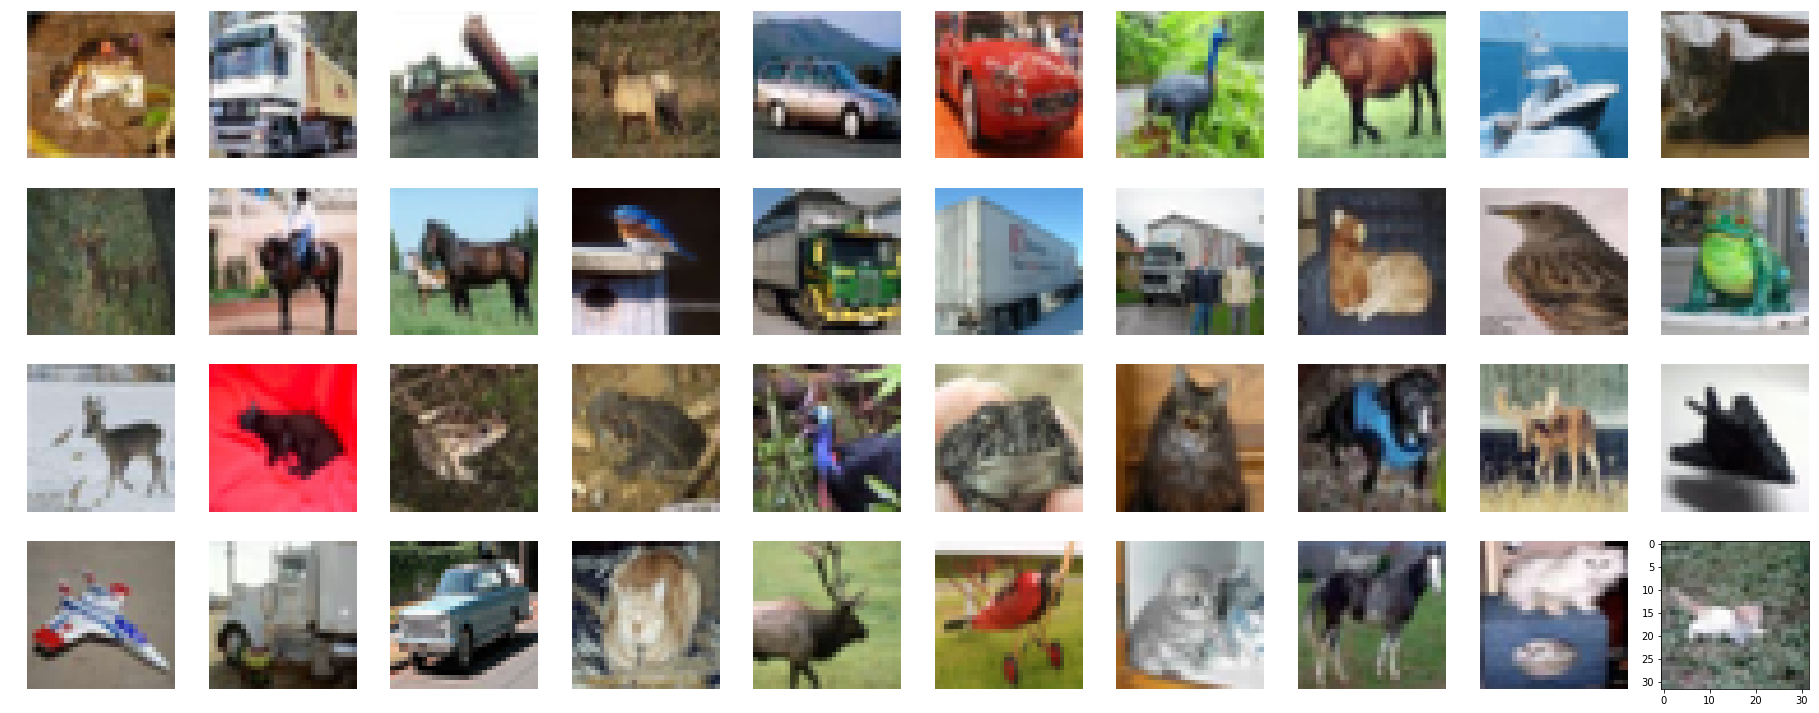

In [57]:
plt.figure(figsize=(32, 32))
for i in range(0,40):
    plt.axis("off")
    plt.subplot(10, 10, i + 1)

    pixels = -np.array(X[i], dtype='float32')
    plt.imshow(pixels, cmap='gray')
    
plt.show()

# Implementation

In [58]:
def weights(spec):
    initial = tf.truncated_normal(spec, stddev=0.1)
    return tf.Variable(initial)

def bias(spec):
    initial = tf.constant(0.1, shape=spec)
    return tf.Variable(initial)

def conv2d(x, W, stride=(1, 1), padding='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, stride[0], stride[1], 1],
                      padding=padding)


def max_pool(x, ksize=(2, 2), stride=(2, 2)):
    return tf.nn.max_pool(x, ksize=[1, ksize[0], ksize[1], 1],
                        strides=[1, stride[0], stride[1], 1], padding='SAME')

In [59]:
# monochrome dataset
# x = tf.placeholder(tf.float32, [None, 32, 32])
# x_shape = tf.reshape(x, [-1, 32, 32, 1])

# color dataset
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
x_shape = tf.reshape(x, [-1, 32, 32, 3])


In [60]:
# use 3 instead of 5
# monochrome
#W1 = weights([3, 3, 1, 32])

# color
W1 = weights([3, 3, 3, 32])
b1 = bias([32])

Conv1 = tf.nn.relu(conv2d(x_shape, W1) + b1)
Pool1 = max_pool(Conv1, ksize=(2, 2), stride=(2, 2))

In [61]:
W2 = weights([3, 3, 32, 64])
b2 = bias([64])

Conv2 = tf.nn.relu(conv2d(Pool1, W2) + b2)
Pool2 = max_pool(Conv2, ksize=(2, 2), stride=(2, 2))

In [62]:
# extra con layer
W25 = weights([3, 3, 64, 64])
b25 = bias([64])

Conv25 = tf.nn.relu(conv2d(Pool2, W25) + b25)
Pool25 = max_pool(Conv25, ksize=(2, 2), stride=(2, 2))

In [63]:
W3 = weights([4 * 4 * 64, 512])
b3 = bias([512])

Flat3 = tf.reshape(Pool25, [-1, 4 * 4 * 64])
HLay3 = tf.nn.relu(tf.matmul(Flat3, W3) + b3)

In [64]:
keep_prob = tf.placeholder(tf.float32)
Drop = tf.nn.dropout(HLay3, keep_prob)

In [65]:
W5 = weights([512, 10])
b5 = bias([10])

y = tf.matmul(Drop, W5) + b5
y_truth = tf.placeholder(tf.float32, [None, 10])

# Train

In [66]:
loss  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_truth, logits=y))
train = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [67]:
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_truth, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [68]:
session = tf.Session()
globalv = tf.global_variables_initializer()

session.run(globalv)

In [69]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [70]:
for i in range(20000):
    xb, yb = next_batch(96, X, Y)
    if i % 100 == 0:
        train_accuracy = session.run(accuracy, feed_dict={x: xb, y_truth: yb, keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    session.run(train, feed_dict={x: xb, y_truth: yb, keep_prob: 0.5})

print("done")

step 0, training accuracy 0.104167
step 100, training accuracy 0.125
step 200, training accuracy 0.166667
step 300, training accuracy 0.114583
step 400, training accuracy 0.104167
step 500, training accuracy 0.114583
step 600, training accuracy 0.09375
step 700, training accuracy 0.177083
step 800, training accuracy 0.0833333
step 900, training accuracy 0.15625
step 1000, training accuracy 0.135417
step 1100, training accuracy 0.15625
step 1200, training accuracy 0.114583
step 1300, training accuracy 0.104167
step 1400, training accuracy 0.229167
step 1500, training accuracy 0.229167
step 1600, training accuracy 0.208333
step 1700, training accuracy 0.166667
step 1800, training accuracy 0.208333
step 1900, training accuracy 0.166667
step 2000, training accuracy 0.125
step 2100, training accuracy 0.177083
step 2200, training accuracy 0.135417
step 2300, training accuracy 0.239583
step 2400, training accuracy 0.197917
step 2500, training accuracy 0.197917
step 2600, training accuracy 0.3

In [71]:
print('test accuracy %g' % session.run(accuracy, feed_dict={x: Xtest, y_truth: Ytest, keep_prob: 1.0}))

test accuracy 0.6848


# Evaluate model

In [72]:
classify = tf.argmax(tf.nn.softmax(y),1)
a  = 512
b  = 554

labels = session.run(classify, feed_dict={x: Xtest[a:b], keep_prob: 1.0})

print(labels)

[6 1 5 3 8 9 7 8 5 7 0 7 0 4 4 0 4 6 9 3 9 5 6 6 6 2 8 0 1 7 6 7 5 9 1 6 5
 5 2 3 8 3]


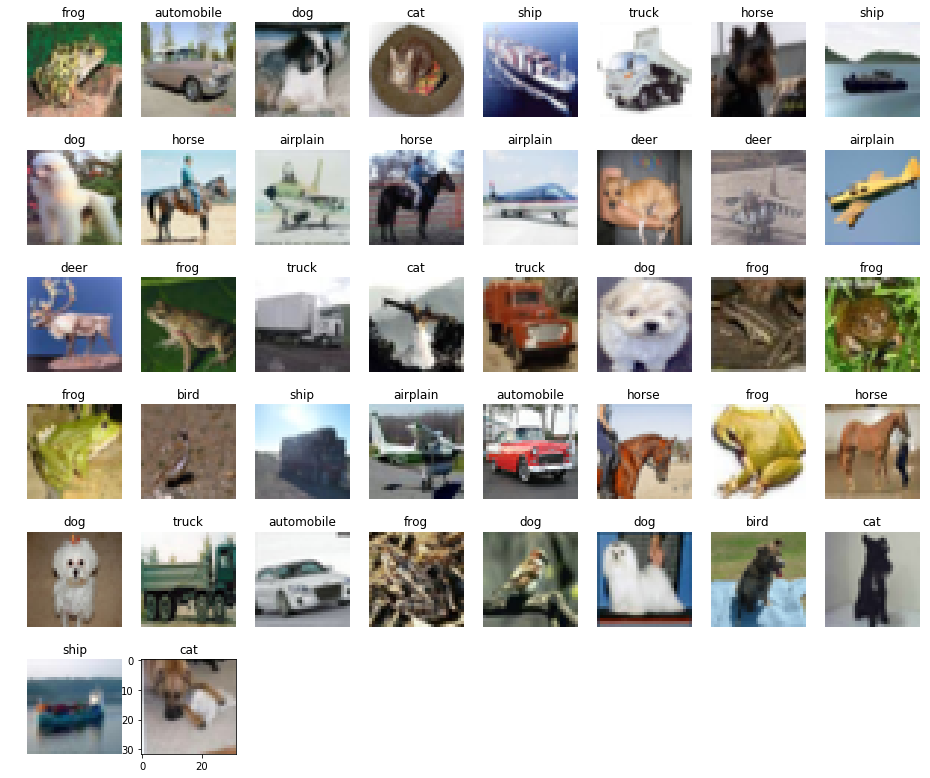

In [75]:
def isa(i):
    if i == 0:
        return 'airplain'
    elif i == 1:
        return 'automobile'
    elif i == 2:
        return 'bird'
    elif i == 3:
        return 'cat'
    elif i == 4:
        return 'deer'
    elif i == 5:
        return 'dog'
    elif i == 6:
        return 'frog'
    elif i == 7:
        return 'horse'
    elif i == 8:
        return 'ship'
    elif i == 9:
        return 'truck'
    else:
        return '-'



plt.figure(figsize=(16, 16))
for i in range(0, b-a):
    plt.axis("off")
    plt.subplot(7, 8, i + 1)

    pixels = -np.array(Xtest[a + i], dtype='float32')

    plt.title('{label}'.format(label=isa(labels[i])))
    plt.imshow(pixels, cmap='gray')
    
plt.show()

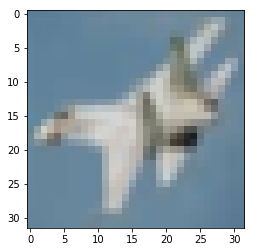

In [76]:
image = Xtest[10:11]
pixels = -np.array(image[0], dtype='float32')
plt.imshow(pixels)    
plt.show()

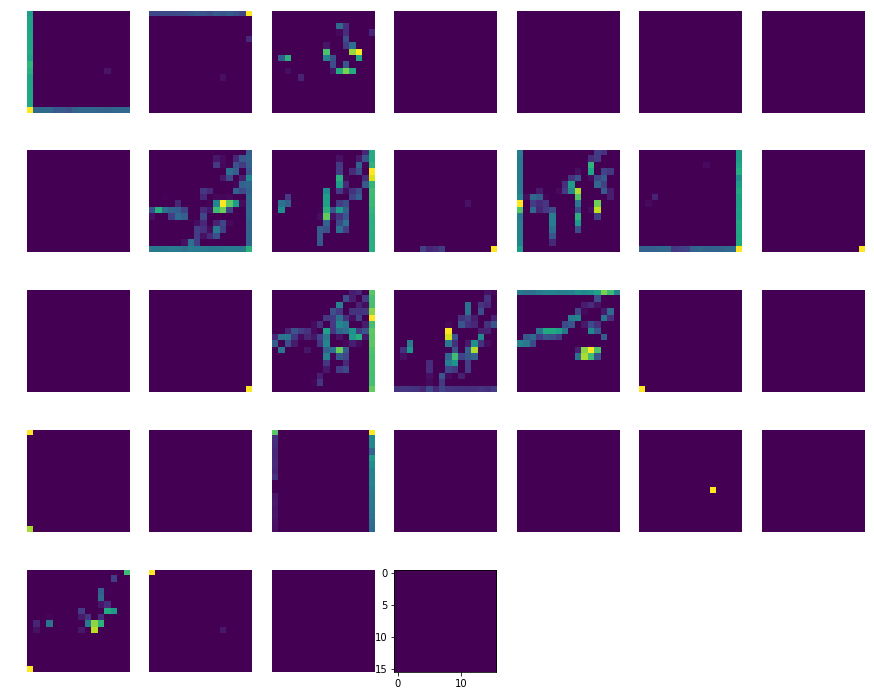

In [77]:
value = session.run(Pool1, feed_dict={x: image, keep_prob: 1.0})

plt.figure(figsize=(15, 15))
for i in range(0, 32):
    plt.axis("off")
    plt.subplot(6, 7, i + 1)
    plt.imshow(value[0, :, :, i])

plt.show()

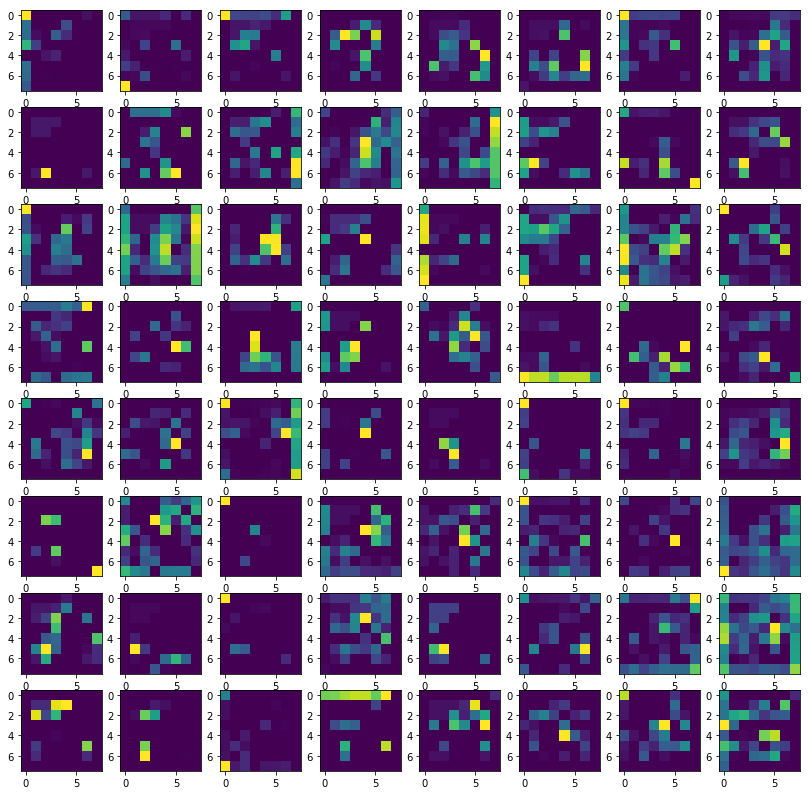

In [78]:
value = session.run(Pool2, feed_dict={x: image, keep_prob: 1.0})

plt.figure(figsize=(14, 14))

for i in range(0, 64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.array(value[0, :, :, i], dtype='float32'))

plt.show()

In [ ]:
#value = session.run(HLay3, feed_dict={x: image, keep_prob: 1.0})
#
#plt.imshow(value.reshape(16, 16))
#plt.show()

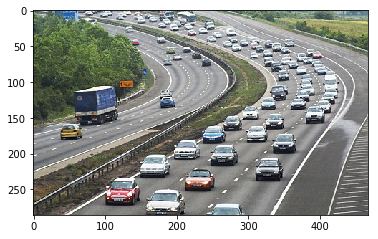

In [119]:
from scipy import misc
from skimage import transform

cars = misc.imread('./png/cars-on-the-road.png')

#cars = transform.rescale(cars, 0.5)

plt.imshow(cars)
plt.show()

In [116]:
from skimage.util.shape import view_as_windows

shift = 4

patch = view_as_windows(cars, (16, 16, 3), step = shift)
print(patch.shape)

(28, 51, 1, 32, 32, 3)


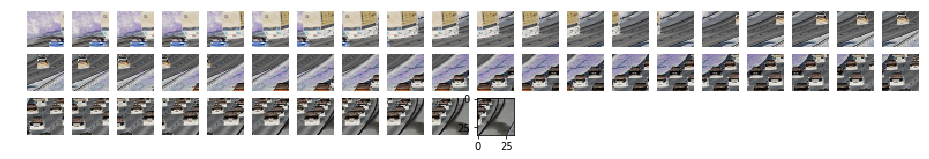

In [117]:
i, j, _, _, _, _ = patch.shape

plt.figure(figsize=(16, 16))
for xi in range(0, j):
    plt.axis("off")
    plt.subplot(20, 20 , xi + 1)
    plt.imshow(np.array(-patch[i//2][xi][0], dtype='float32'))

plt.show()

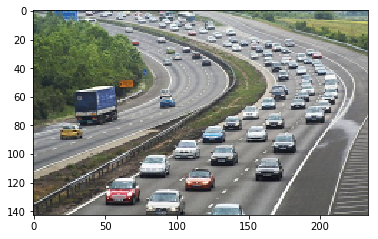

In [118]:
import matplotlib.patches as patches

job = patch.reshape((i*j*1, 32, 32, 3))
spot = session.run(classify, feed_dict={x: job, keep_prob: 1.0})

spot = spot.reshape((i,j))

fig,ax = plt.subplots(1)
ax.imshow(cars)


for xi in range(0, i):
    for yi in range (0, j):
        if spot[xi][yi] == 1:
            rect = patches.Rectangle((xi * shift, yi * shift),32,32,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        elif spot[xi][yi] == 9:
            rect = patches.Rectangle((xi * shift, yi * shift),32,32,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)

plt.show()        
            